Kickstarter es una plataforma de financiamiento colaborativo donde una persona puede pedir ayuda para realizar un proyecto de diversos temas, como juegos, peliculas, arte y muchos mas. El creador del proyecto sube a la plataforma el proyecto que desea hacer realidad, y las personas , si les gusta el proyecto, lo patrocinan.

Para más información ver el siguiente enlace: https://www.kickstarter.com/help/taxes?lang=es

En ele presente trabajo se tomó como base el dataset del siguiente enlace:
https://webrobots.io/kickstarter-datasets/
Este dataset contiene el registro de miles de proyectos de la plataforma Kickstarter, se puede saber en que fecha fueron creados, su categoría, y si fué exitoso o no.


El primer paso a seguir, luego de descargar los datos en formato csv, es consolidar todos ellos en un solo archivo para facilitar el procesamiento. A continuación el código en python 3 usado para esto

In [ ]:
# Este código debe ser ejecutado en la misma carpeta donde se encuentren los archivos
# csv descargados y descomprimidos. Asegurar que no exista otro archivo csv ajeno a los de Kickstarter



# Paquetes a importar, para manejar los datos en un dataframe
import glob
import pandas 


def ReadFile(path):
    # Dada la ruta de un archivo, se lee este, y se separan ciertas columnas de interés para analizar
    # no todas las columnas tienen información relevante
    file = pandas.read_csv(path, skiprows = 0, sep = ',', header=0,
                 usecols = ['id', 'name', 'blurb', 'goal',
                            'state', 'pledged', 'state', 'country',
                            'currency', 'deadline', 'launched_at',
                            'backers_count', 'creator', 'location',
                            'category', 'spotlight', 'staff_pick'])

    # La columna location tiene un formato json con muchos campos innecesarios
    # se debe separar la información pedida, en este caso la ciudad en donde se realizó el proyecto
    file['location'] = file['location'].str.split('displayable_name').str[1]
    file['location'] = file['location'].str.split('"').str[2]
    
    # La columna creator tiene un formato json con muchos campos innecesarios
    # se debe separar la información pedida, en este caso el nombre de la persona o entidad que creó el proyecto
    file['creator'] = file['creator'].str.split(':').str[10]
    file['creator'] = file['creator'].str.split(',').str[0]
    
    # la columna category tambien tiene un formato json con campos innecesarios, se separa la categoría del proyecto
    file['category'] = file['category'].str.split(':').str[-1]
    file['category'] = file['category'].str.split('"').str[1]
    # Tambien se obtiene la subcategoría de cada proyecto
    file['subcategory'] = file['category'].str.split('/').str[1]
    file['category'] = file['category'].str.split('/').str[0]
    
    # Los campos deadline (que indica el momento en que terminó el proyecto) y 
    # launched_at (que indica el momento en que inició un proyecto) están en formato timestamp de unix
    # así que se deben transformar a una fecha legible
    file['deadline']=pandas.to_datetime(file['deadline'], unit='s')
    file['launced_at']=pandas.to_datetime(file['launched_at'], unit='s')
    
    # Este campo tiene la descripción del proyecto, para evitar problemas de lectura posteriores
    # se reemplazan los ; por .
    file['blurb'] = file['blurb'].replace(';', '.')
    
    # se filtran los proyectos por aquellos que fueron exitoso y fallidos
    # pues el objetivo es predecir si un poryecto será exitoso o no
    file.drop( 
            file[(file['state'] != 'successful') & (file['state'] != 'failed') ].index, 
            inplace = True)
  
    return file

# Se toma el nombre de todos los archivos .csv que existan en la carpeta actual
pathFiles = glob.glob('*.csv')
# se descarta el archivo consolidado.csv, que será el archivo con todos los datos en uno solo
if ("consolidado.csv" in pathFiles):
    pathFiles.remove('consolidado.csv')
    
# este será el dataframe que contendrá la información
bigFile = pandas.DataFrame()
    
# Procesa cada archivo y lo anexa a un solo DataFrame
for path in pathFiles:
    print(path)
    bigFile = bigFile.append(ReadFile(path), ignore_index = True)

# eliminar filas duplicadas
bigFile.drop_duplicates(inplace = True)


# Guardar archivo
print("Guardando archivo consolidado")
bigFile.to_csv("consolidado.csv", sep = ";", na_rep = '', index = False)



In [ ]:
Continuando con un análisis

A continuación se muestra un análisis de los proyectos por categorías

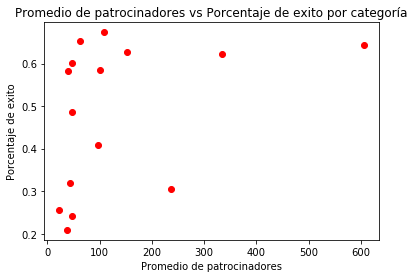

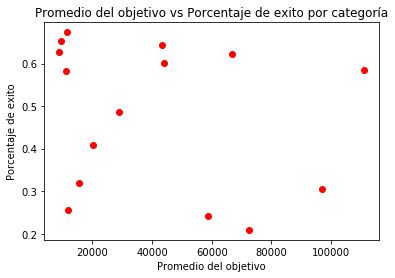

       Categoria  Patrocinadores     Exito  Cantidad       Objetivo
0         crafts       23.351607  0.255166      3484   11958.140069
1     journalism       38.500198  0.208878      2523   72587.162109
2          dance       40.335622  0.581998      1311   10999.266972
3    photography       43.313273  0.318404      4287   15380.141124
4        theater       46.487239  0.601218      3448   44139.683585
5            art       46.898684  0.485204     16187   28829.748452
6           food       47.866774  0.240721     11154   58606.171149
7          music       63.411879  0.653443     22611    9346.768116
8        fashion       97.524663  0.407580      7704   20189.291277
9   film & video      101.426136  0.585731     21235  110985.254058
10    publishing      107.742941  0.673688     15335   11574.202705
11        comics      153.018443  0.626064      4934    8923.121605
12    technology      237.167679  0.304736     16132   97134.643334
13        design      333.221021  0.622222      

In [1]:
import pandas 
import matplotlib.pyplot as plt
import numpy as np

# Leer el archivo consolidado
file = pandas.read_csv("consolidado.csv", skiprows = 0, sep = ';', header=0)

# Para obtener el promedio de exito, reemplazar un exito con 1, fracaso con 0
file['state'] = file['state'].replace('successful', 1)
file['state'] = file['state'].replace('failed', 0)

# Por categoría, obtener la cantidad de proyectos, el porcentaje de exitos
# el promedio de patrocinadores y el promedio del tamaño del objetivo
frecuenciaCategoria = file.groupby('category').agg(
        {'backers_count':'mean', 'state':'mean', 'category':'count',
         'goal': 'mean'}
   )
# Renombrar las columnas para un mas fácil uso
frecuenciaCategoria.columns = ['Patrocinadores', 'Exito', 'Cantidad', 'Objetivo']
frecuenciaCategoria.reset_index(inplace=True)
frecuenciaCategoria.columns = ['Categoria', 'Patrocinadores', 'Exito', 'Cantidad', 'Objetivo']


# Reordenar según el promedio de patrocinadores
frecuenciaCategoria.sort_values(by = ['Patrocinadores'], inplace = True)
frecuenciaCategoria.reset_index(inplace=True, drop = True)

# Graficar el promedio de patrocinadores vs el éxito obtenido
plt.figure()
plt.plot( list(frecuenciaCategoria['Patrocinadores']), 
          list(frecuenciaCategoria['Exito']),
          'ro')
plt.title('Promedio de patrocinadores vs Porcentaje de exito por categoría')
plt.xlabel('Promedio de patrocinadores')
plt.ylabel('Porcentaje de exito')
plt.show(block=False)


# Graficar el tamaño promedio del objetivo vs el éxito obtenido
plt.figure()
plt.plot( list(frecuenciaCategoria['Objetivo']), 
          list(frecuenciaCategoria['Exito']),
          'ro')
plt.title('Promedio del objetivo vs Porcentaje de exito por categoría')
plt.xlabel('Promedio del objetivo')
plt.ylabel('Porcentaje de exito')
plt.show(block=False)

print(frecuenciaCategoria)

Las gráficas anteriores indica que hay cierta tendencia a que los proyectos sean mas exitosos a medida que el proyecto tiene mas patrocinadores, aunque esto no se cumple para la categoría "technology"

A continuación se procede a buscar las categorías mas exitosas, así como las que tiene mas patrocinadores

In [2]:
# se reordena la tabla de frecuencias según la variable 'Patrocinadores', 
# para saber cual categoría tiene mas y cual menos
frecuenciaCategoria.sort_values(
        by = ['Patrocinadores'], 
        ascending=[1], 
        inplace = True)
frecuenciaCategoria.reset_index(inplace=True, drop=True)   


print("Categorías más apoyadas: ")
for i in range(0, 5):
    n = len(frecuenciaCategoria)-1-i
    print( frecuenciaCategoria.loc[n, 'Categoria'] + ': ' 
          + str(int(frecuenciaCategoria.loc[n, 'Patrocinadores'])) 
          + ' patrocinadores por proyecto')
  
print('')
print('')

print("Categorías menos apoyadas: ")
for i in range(0, 5):
    print( frecuenciaCategoria.loc[i, 'Categoria'] + ': ' 
          + str(int(frecuenciaCategoria.loc[i, 'Patrocinadores']))  
          + ' patrocinadores por proyecto')

Categorías más apoyadas: 
games: 605 patrocinadores por proyecto
design: 333 patrocinadores por proyecto
technology: 237 patrocinadores por proyecto
comics: 153 patrocinadores por proyecto
publishing: 107 patrocinadores por proyecto


Categorías menos apoyadas: 
crafts: 23 patrocinadores por proyecto
journalism: 38 patrocinadores por proyecto
dance: 40 patrocinadores por proyecto
photography: 43 patrocinadores por proyecto
theater: 46 patrocinadores por proyecto


In [5]:
 # reordenar según el exito promedio de la categoría
frecuenciaCategoria.sort_values(
        by = ['Exito'], 
        ascending=[1], 
        inplace = True)
frecuenciaCategoria.reset_index(inplace=True, drop=True)   
 
  
print("Categorías mas exitosas: ")
for i in range(0, 5):
    n = len(frecuenciaCategoria)-1-i
    print( frecuenciaCategoria.loc[n, 'Categoria'] + ': ' 
          + str(int(frecuenciaCategoria.loc[n, 'Exito'] * 100))  
          + '%')
print('')
print('')    

print("Categorías menos exitosas: ")
for i in range(0, 5):
    print( frecuenciaCategoria.loc[i, 'Categoria'] + ': ' 
          + str(int(frecuenciaCategoria.loc[i, 'Exito'] * 100))  
          + '%')


Categorías mas exitosas: 
publishing: 67%
music: 65%
games: 64%
comics: 62%
design: 62%


Categorías menos exitosas: 
journalism: 20%
food: 24%
crafts: 25%
technology: 30%
photography: 31%


In [6]:
frecuenciaCategoria.sort_values(
        by = ['Objetivo'], 
        ascending=[1], 
        inplace = True)
frecuenciaCategoria.reset_index(inplace=True, drop=True)   

print("Categorías más ambiciosas: ")
for i in range(0, 5):
    n = len(frecuenciaCategoria)-1-i
    print( frecuenciaCategoria.loc[n, 'Categoria'] + ': ' 
          + str(int(frecuenciaCategoria.loc[n, 'Objetivo']))
          + '$ por proyecto')

print('')
print('')


print("Categorías menos ambiciosas: ")
for i in range(0, 5):
    print( frecuenciaCategoria.loc[i, 'Categoria'] + ': ' 
          + str(int(frecuenciaCategoria.loc[i, 'Objetivo']))
          + '$ por proyecto')    
    
 

Categorías más ambiciosas: 
film & video: 110985$ por proyecto
technology: 97134$ por proyecto
journalism: 72587$ por proyecto
design: 66682$ por proyecto
food: 58606$ por proyecto


Categorías menos ambiciosas: 
comics: 8923$ por proyecto
music: 9346$ por proyecto
dance: 10999$ por proyecto
publishing: 11574$ por proyecto
crafts: 11958$ por proyecto


Sistema de predicción de exito o fracaso de un proyecto.

In [1]:
#Arbol con ensable de estimadores

from sklearn import tree  
import pydotplus  
from IPython.display import Image  
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
import sklearn.metrics as sm
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import BaggingClassifier

#Lectura archivo
data=pd.read_csv('consolidado.csv',  # el archivo
                    sep = ';',         # separador de campos
                    thousands = None,  # separador de miles para números
                    decimal = '.',
                    skiprows = 0,
                    header=0)     # separador de los decimales para números

#Semanas campaña
data['semanas_campana'] = ((pd.to_datetime(data['deadline']) - pd.to_datetime(data['launched_at']))/ np.timedelta64(1, 'W')).astype(int)

#Longitud descripcion
sizes = [len(i) for i in data['blurb'].astype(str)]
data['longitud_descripcion']=sizes

#Variables dummy de categoria
df_categoria = pd.get_dummies(data['category'])
data = data.join(df_categoria)

#Variables dummy de country
df_country = pd.get_dummies(data['country'])
data = data.join(df_country)

#Variables dummy de subcategory
df_subcategory = pd.get_dummies(data['subcategory'])
data = data.join(df_subcategory)

#Normalizar valor objetivo
#data['goal'] = preprocessing.scale(data['goal'])
#longitud_descripcion
cols = ['goal', 'semanas_campana', 'art', 'comics', 'crafts',
       'dance', 'design', 'fashion', 'film & video', 'food', 'games',
       'journalism', 'music', 'photography', 'publishing', 'technology',
       'theater', 
       'AT', 'AU', 'BE', 'CA', 'CH', 'DE', 'DK', 'ES', 'FR', 'GB', 'HK', 'IE', 'IT', 'JP', 'LU', 'MX', 'NL', 'NO', 
'NZ', 'SE', 'SG', 'US', '3d printing', 'academic', 'accessories', 'action', 'animals', 'animation', 'anthologies', 
'apparel', 'apps', 'architecture', 'art books', 'audio', 'bacon', 'blues', 'calendars', 'camera equipment', 'candles', 
'ceramics', 'children\'s books', 'childrenswear', 'chiptune', 'civic design', 'classical music', 'comedy', 
'comic books', 'community gardens', 'conceptual art', 'cookbooks', 'country & folk', 'couture', 'crochet', 
'digital art', 'diy', 'diy electronics', 'documentary', 'drama', 'drinks', 'electronic music', 'embroidery', 
'events', 'experimental', 'fabrication tools', 'faith', 'family', 'fantasy', 'farmer\'s markets', 'farms', 
'festivals', 'fiction', 'fine art', 'flight', 'food trucks', 'footwear', 'gadgets', 'gaming hardware', 'glass', 
'graphic design', 'graphic novels', 'hardware', 'hip-hop', 'horror', 'illustration', 'immersive', 'indie rock', 
'installations', 'interactive design', 'jazz', 'jewelry', 'kids', 'knitting', 'latin', 'letterpress', 
'literary journals', 'literary spaces', 'live games', 'makerspaces', 'metal', 'mixed media', 'mobile games', 
'movie theaters', 'music videos', 'musical', 'narrative film', 'nature', 'nonfiction', 'painting', 'people', 
'performance art', 'performances', 'periodicals', 'pet fashion', 'photo', 'photobooks', 'places', 'playing cards', 
'plays', 'poetry', 'pop', 'pottery', 'print', 'printing', 'product design', 'public art', 'punk', 'puzzles', 
'quilts', 'r&b', 'radio & podcasts', 'ready-to-wear', 'residencies', 'restaurants', 'robots', 'rock', 'romance', 
'science fiction', 'sculpture', 'shorts', 'small batch', 'software', 'sound', 'space exploration', 'spaces', 
'stationery', 'tabletop games', 'taxidermy', 'television', 'textiles', 'thrillers', 'translations', 'typography', 
'vegan', 'video', 'video art', 'video games', 'wearables', 'weaving', 'web', 'webcomics', 'webseries', 'woodworking', 
'workshops', 'world music', 'young adult', 'zines', 'state'
]

data=data[cols]
# longitud_descripcion
data.columns=['goal', 'semanas_campana', 'art', 'comics', 'crafts',
       'dance', 'design', 'fashion', 'film \& video', 'food', 'games',
       'journalism', 'music', 'photography', 'publishing', 'technology',
       'theater',
       'AT', 'AU', 'BE', 'CA', 'CH', 'DE', 'DK', 'ES', 'FR', 'GB', 'HK', 'IE', 'IT', 'JP', 'LU', 'MX', 'NL', 'NO', 
'NZ', 'SE', 'SG', 'US', '3d printing', 'academic', 'accessories', 'action', 'animals', 'animation', 'anthologies', 
'apparel', 'apps', 'architecture', 'art books', 'audio', 'bacon', 'blues', 'calendars', 'camera equipment', 'candles', 
'ceramics', 'children\'s books', 'childrenswear', 'chiptune', 'civic design', 'classical music', 'comedy', 
'comic books', 'community gardens', 'conceptual art', 'cookbooks', 'country \& folk', 'couture', 'crochet', 
'digital art', 'diy', 'diy electronics', 'documentary', 'drama', 'drinks', 'electronic music', 'embroidery', 
'events', 'experimental', 'fabrication tools', 'faith', 'family', 'fantasy', 'farmer\'s markets', 'farms', 
'festivals', 'fiction', 'fine art', 'flight', 'food trucks', 'footwear', 'gadgets', 'gaming hardware', 'glass', 
'graphic design', 'graphic novels', 'hardware', 'hip-hop', 'horror', 'illustration', 'immersive', 'indie rock', 
'installations', 'interactive design', 'jazz', 'jewelry', 'kids', 'knitting', 'latin', 'letterpress', 
'literary journals', 'literary spaces', 'live games', 'makerspaces', 'metal', 'mixed media', 'mobile games', 
'movie theaters', 'music videos', 'musical', 'narrative film', 'nature', 'nonfiction', 'painting', 'people', 
'performance art', 'performances', 'periodicals', 'pet fashion', 'photo', 'photobooks', 'places', 'playing cards', 
'plays', 'poetry', 'pop', 'pottery', 'print', 'printing', 'product design', 'public art', 'punk', 'puzzles', 
'quilts', 'r\&b', 'radio \& podcasts', 'ready-to-wear', 'residencies', 'restaurants', 'robots', 'rock', 'romance', 
'science fiction', 'sculpture', 'shorts', 'small batch', 'software', 'sound', 'space exploration', 'spaces', 
'stationery', 'tabletop games', 'taxidermy', 'television', 'textiles', 'thrillers', 'translations', 'typography', 
'vegan', 'video', 'video art', 'video games', 'wearables', 'weaving', 'web', 'webcomics', 'webseries', 'woodworking', 
'workshops', 'world music', 'young adult', 'zines', 'state'
]

cols=data.columns

data["state"]= data['state'].map({'successful': 1, 'failed': 0})
           
#data.to_csv("dataset_arbol.csv", sep = ";", na_rep = '', index = False)

features = list(cols[:183])
data = data.as_matrix()
data = np.matrix(data)

X_train, X_test, y_train, y_test = train_test_split(
    data[:,:-1], np.ravel(data[:,183:184]), test_size=0.30, random_state=42)

tree1 = DecisionTreeClassifier()

bag = BaggingClassifier(tree1, n_estimators=100, max_samples=0.8, random_state=1)
bag1=bag.fit(X_train, y_train)


y_pred=bag1.predict(X_test)

accuracy = sm.accuracy_score(y_test, y_pred)

print("Precision: %.2f%%" % (accuracy*100.0))
print("MSE:",mean_squared_error(y_test, y_pred))

#Se deshabilitar el grafico del arbol porque no funciona al incluir el ensable de estimadores (BaggingClassifier)
#Se exporta el arbol al formato Graphviz 
#with open("iris.dot", 'w') as f:
#    f = tree.export_graphviz(bag1, out_file=f)
    
#export_graphviz soporta otras opciones tal como colorear y la funcion Image permite renderizar la imagen en el libro de Ipython
#dot_data = tree.export_graphviz(bag1, out_file=None, 
#                     feature_names=features,  
#                     class_names=['failed', 'succesful'],  
#                     filled=True, rounded=True,  
#                     special_characters=True)  
#graph = pydotplus.graph_from_dot_data(dot_data)  
#Image(graph.create_png())



C:\Users\herngaga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Precision: 72.16%
MSE: 0.27841197948


In [2]:
Analisis de volumen de patrocinadores, valor metas y exito y fallo de una campaña

SyntaxError: invalid syntax (<ipython-input-2-6c7ade3299ff>, line 1)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

#Lectura archivo
data=pd.read_csv('consolidado.csv',  # el archivo
                    sep = ';',         # separador de campos
                    thousands = None,  # separador de miles para números
                    decimal = '.',
                    skiprows = 0,
                    header=0)     # separador de los decimales para números
labels=['[1-2]', '(2-6]', '(6-14]', '(14-29]', '(29-51]', '(51-88]', '(88-189]', '(189-105857]']
data_bakers=data.loc[data['backers_count'] > 0]
#print(data_bakers.columns)

data_bakers['Cant Patrocinadores']=pd.qcut(data_bakers['backers_count'], 8,labels=labels)

#Dinero obtenido
bins_dinero=data_bakers[['Cant Patrocinadores', 'goal', 'pledged']]

bins_dinero.columns=['Cant Patrocinadores', 'Objetivo', 'Obtenido']

bins_dinero=bins_dinero.groupby('Cant Patrocinadores').sum()

#Estados
df_state = pd.get_dummies(data_bakers['state'])
data_bakers = data_bakers.join(df_state)

bins_states=data_bakers[['Cant Patrocinadores', 'failed', 'successful']]

bins_states.columns=['Cant Patrocinadores', 'Fallido', 'Exitoso']

bins_states=bins_states.groupby('Cant Patrocinadores').sum()

#Objetivos vs patrocinadores

labels=['(0-750]', '(750-1700]', '(1700-3000]', '(3000-5000]', '(5000-8000]', '(8000-15000]', '(15000-30000]', '(30000-100 Mill]']
data_objetivo=data.loc[data['goal'] > 0]


#Objetivo vs Patrocinadores
df_state = pd.get_dummies(data_bakers['state'])
data_objetivo = data_objetivo.join(df_state)

data_objetivo['failed_bakers']=data_objetivo['failed']*data_objetivo['backers_count']
data_objetivo['successful_bakers']=data_objetivo['successful']*data_objetivo['backers_count']

data_objetivo['Valor Objetivo']=pd.qcut(data_objetivo['goal'], 8,labels=labels)

bins_objetivo_bakers=data_objetivo[['Valor Objetivo', 'failed_bakers', 'successful_bakers']]

bins_objetivo_bakers=bins_objetivo_bakers.groupby('Valor Objetivo').sum()

#print(bins_objetivo_bakers)
bins_objetivo_bakers_porc_falledo=(bins_objetivo_bakers['failed_bakers']/(bins_objetivo_bakers['failed_bakers']+bins_objetivo_bakers['successful_bakers']))*100
bins_objetivo_bakers_porc_exito=(bins_objetivo_bakers['successful_bakers']/(bins_objetivo_bakers['failed_bakers']+bins_objetivo_bakers['successful_bakers']))*100
bins_objetivo_bakers['successful_bakers']=bins_objetivo_bakers_porc_exito
bins_objetivo_bakers['failed_bakers']=bins_objetivo_bakers_porc_falledo

#print(bins_objetivo_bakers)

bins_objetivo_bakers.columns=['% Patrocinadores Campañas Fallidas', '% Patrocinadores Campañas Exitosas']



#Objetivos vs recolectado

data_objetivo['failed_recogido']=(data_objetivo['failed']*data_objetivo['pledged'])/1000000
data_objetivo['successful_recogido']=(data_objetivo['successful']*data_objetivo['pledged'])/1000000

bins_objetivo_recogido=data_objetivo[['Valor Objetivo', 'failed_recogido', 'successful_recogido']]

bins_objetivo_recogido.columns=['Valor Objetivo', 'Millones Recolectado Campañas Fallidas', 'Millones Recolectado Campañas Exitosas']

bins_objetivo_recogido=bins_objetivo_recogido.groupby('Valor Objetivo').sum()



#Objetivos vs exito

data_objetivo['failed_recogido']=(data_objetivo['failed']*data_objetivo['pledged'])/1000000
data_objetivo['successful_recogido']=(data_objetivo['successful']*data_objetivo['pledged'])/1000000

bins_objetivo_exito=data_objetivo[['Valor Objetivo', 'failed', 'successful']]

bins_objetivo_exito.columns=['Valor Objetivo', 'Fallido', 'Exitoso']

bins_objetivo_exito=bins_objetivo_exito.groupby('Valor Objetivo').sum()

bins_objetivo_exito_porc_falledo=(bins_objetivo_exito['Fallido']/(bins_objetivo_exito['Fallido']+bins_objetivo_exito['Exitoso']))*100
bins_objetivo_exito_porc_exito=(bins_objetivo_exito['Exitoso']/(bins_objetivo_exito['Fallido']+bins_objetivo_exito['Exitoso']))*100
bins_objetivo_exito['Exitoso']=bins_objetivo_exito_porc_exito
bins_objetivo_exito['Fallido']=bins_objetivo_exito_porc_falledo

bins_objetivo_exito.columns=['% Fallos', '% Exitos']

#El exito de un proyecto depende del volumen de apoyo que recibe.
bins_states.plot.bar(stacked=True,figsize=(10, 6));

#La cantidad de dinero recolectado aumenta con la meta. Entonces no se ve un fenomeno marcado de pocos dan mucho.
bins_objetivo_recogido.plot.bar(stacked=True,figsize=(10, 6));

#Mientras mayor sea la meta mas probabilidad de que falle el proyecto
bins_objetivo_exito.plot.bar(figsize=(10, 6));

#A pesar de que la probabilidad de fallo aumenta con el valor de  la meta, no cambia el porcentaje de patrocinadores 
# que apoyan las campañas exitosas. Es decir, muchos patrocinadores apoyan unos pocos proyectos
bins_objetivo_bakers.plot.bar(figsize=(10, 6));

plt.show()
